In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.realpath('..'))

In [2]:
import numpy as np
import plotly.express as ex
import pandas as pd

from tracking.motion import ConstantVelocityModel
from tracking.target import ConstantVelocityTarget
from tracking.util import to_df

In [3]:
def xyz_to_rbe(a):
    assert a.shape[1] == 3
    
    sq = np.power(a, 2)
    r  = np.sqrt(sq.sum(axis=1))
    rh = np.sqrt(sq[:, :2].sum(axis=1))

    az = np.arctan2(a[:,1], a[:,0])
    el = np.arctan2(a[:,2], rh)

    rbe = np.array((r, az, el)).T
    return rbe

def rbe_to_xyz(a):
    r, b, e = a[:,0], a[:,1], a[:,2]
    z = r * np.sin(e)
    x2y2 = r * np.cos(e)
    x = x2y2 * np.cos(b)
    y = x2y2 * np.sin(b)
    
    return np.array((x, y, z)).T

In [4]:
def rbe_measurements(positions, noise_covariance=[10, .1, .1], seed=0):
    rbe = xyz_to_rbe(positions)
    if noise_covariance is None:
        return rbe
        
    noise_covariance = np.array(noise_covariance)
    if len(noise_covariance.shape) == 1:
        noise_covariance = np.diag(noise_covariance)

    noise_mean = np.full(rbe.shape[1], 0)
    rnd = np.random.default_rng(seed=seed)
    noise = rnd.multivariate_normal(noise_mean, noise_covariance, size=rbe.shape[0])
    assert rbe.shape == noise.shape
    
    return rbe + noise

In [5]:
rbe_measurements(np.array([[1000, 1000, 0]]), None) - np.array([[np.sqrt(2)*1000, np.pi/4, 0]]), \
rbe_measurements(np.array([[5000, 1000, 0]]), None) - np.array([[np.sqrt(26)*1000, np.arctan2(1, 5), 0]]), \
rbe_measurements(np.array([[-5000, 1000, 0]]), None) - np.array([[np.sqrt(26)*1000, np.arctan2(1, -5), 0]])

(array([[0., 0., 0.]]),
 array([[9.09494702e-13, 0.00000000e+00, 0.00000000e+00]]),
 array([[9.09494702e-13, 0.00000000e+00, 0.00000000e+00]]))

In [6]:
target = ConstantVelocityTarget(initial_position=[-5000, 1000, 0])
truth = target.true_states()

meas_cov = np.diag([1, 0.0007, 0.0007]) # var=0.0007 rad^2 -> sd = 1.5 deg
measurements = rbe_measurements(truth[:,:3], noise_covariance=meas_cov)

In [7]:
measurements

array([[ 5.09914524e+03,  2.96114108e+00, -3.49516615e-03],
       [ 5.06971041e+03,  2.95260346e+00, -1.41724795e-02],
       [ 5.04150241e+03,  2.92324338e+00,  2.50574070e-02],
       ...,
       [ 6.98057451e+03,  1.01959711e-01, -2.18211962e-02],
       [ 7.01092919e+03,  1.62625696e-01,  1.54216107e-02],
       [ 7.04167738e+03,  1.11456271e-01,  7.06658908e-03]])

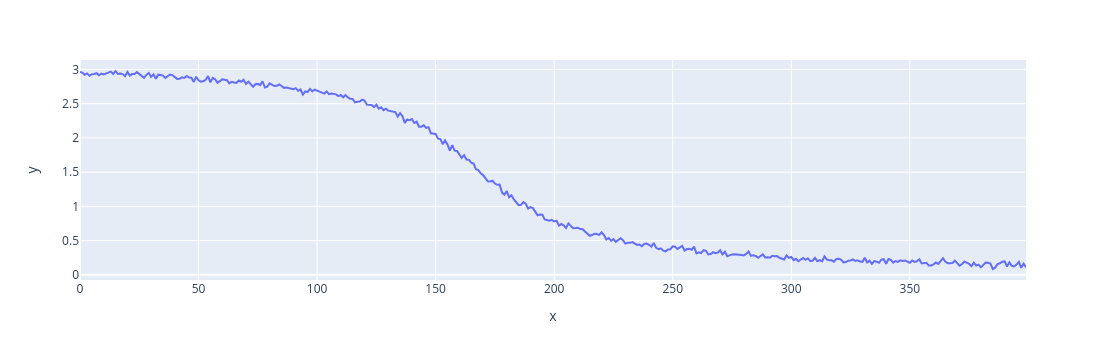

In [8]:
ex.line(y=measurements[:,1])

In [9]:
class ExtendedKalmanFilter(object):
    def __init__(self):
        self.x = np.zeros((6, 1)) # column vector
        self.P = np.eye(6)
        self.motion_model = ConstantVelocityModel()
        self.spatial_dim = 3

        self.x_hat = None
        self.P_hat = None

    def initialize(self, z, R):
        z, R = np.array(z), np.array(R)
        r, c = R.shape
        
        z.shape = (3, 1)
        self.x[:3,0] = rbe_to_xyz(z.reshape((1, 3)))

        H = self.H(*self.x[:3, 0])
        H = H[:r, :c]
        H = np.linalg.inv(H)
        
        self.P[:r,:c] = H @ R @ H.T
    
    def predict(self, dt):
        F = self.motion_model.F(dt)
        Q = self.motion_model.Q(dt)
        
        self.x_hat = F @ self.x
        self.x = np.copy(self.x_hat)
        
        self.P_hat = F @ self.P @ F.T + Q
        self.P = np.copy(self.P_hat)

    # measurement matrix
    def H(self, x, y, z):
        x2y2 = x**2 + y**2
        x2y2z2 = x2y2 + z**2
        
        r = np.sqrt(x2y2z2)
        u = np.sqrt(x2y2) * x2y2z2

        # range, bearing, elevation
        return np.array([
            [x/r, y/r, z/r, 0, 0, 0],
            [-y/x2y2, x/x2y2, 0, 0, 0, 0],
            [x*z/u, y*z/u, x2y2/x2y2z2, 0, 0, 0]
        ])

    def update(self, z, R):
        z = np.array(z); z.shape = (self.spatial_dim, 1) # measurement, column vector
        
        H = self.H(*self.x[:3, 0])
        z_hat = xyz_to_rbe(self.x[:3, 0].reshape((1, 3)))
        z_hat.shape = (self.spatial_dim, 1)
        
        # innovation covariance
        # S = H*P*H + R
        S = H @ self.P @ H.T + R

        # Kalman gain
        # K = P*H (H*P*H + R)^-1
        K = self.P @ H.T @ np.linalg.inv(S)

        # filtered state (mean)
        # X = X + K(z - H*X)
        x = self.x + K @ (z - z_hat)
        
        # filtered state (covariance)
        # P = P - K*S*K
        P = self.P - K @ S @ K.T

        self.x = x
        self.P = P
        self.K = K

In [10]:
kf = ExtendedKalmanFilter()

In [11]:
# initialize track state
kf.initialize(measurements[0,:], meas_cov)

# iterate and collect state estimates
x_hat, P_hat, K = [], [], []
for z in measurements[1:,:]:
    kf.predict(1)
    x_hat.append(np.squeeze(kf.x_hat))
    P_hat.append(kf.P_hat)
    
    kf.update(z, meas_cov)
    K.append(kf.K)

x_hat, P_hat, K = np.array(x_hat), np.array(P_hat), np.array(K)

df = pd.concat((to_df(truth).assign(data='truth'), to_df(x_hat).assign(data='est'), to_df(rbe_to_xyz(measurements)).assign(data='meas')))
err = pd.concat((to_df(x_hat-truth[1:,]).assign(data='est'), to_df(rbe_to_xyz(measurements)-truth[:,:3]).assign(data='meas')))

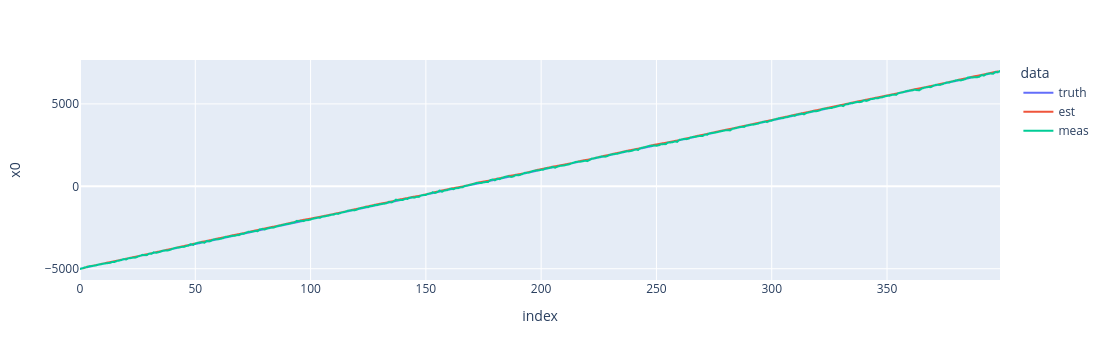

In [12]:
ex.line(df, y='x0', color='data')

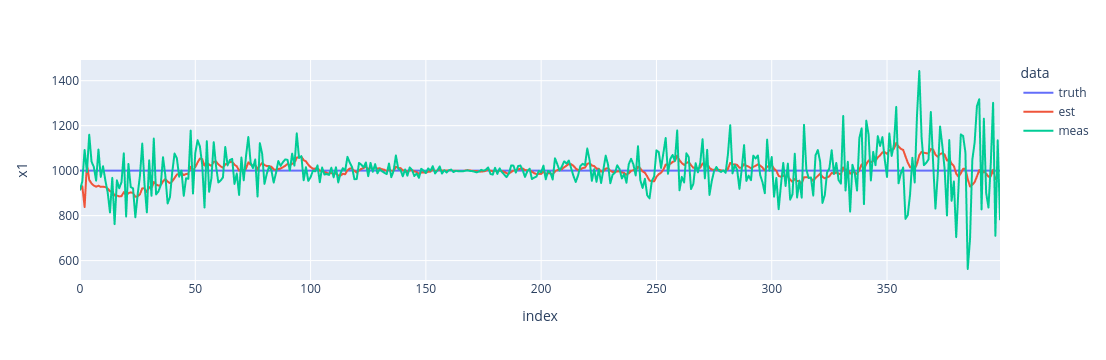

In [13]:
ex.line(df, y='x1', color='data')

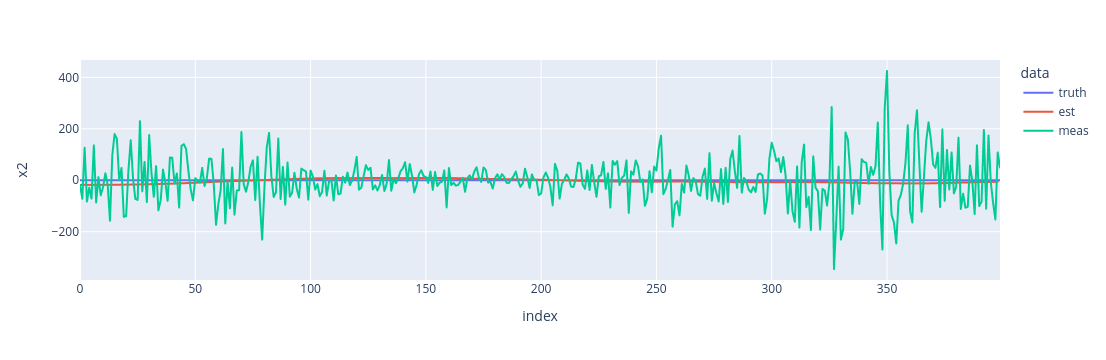

In [14]:
ex.line(df, y='x2', color='data')

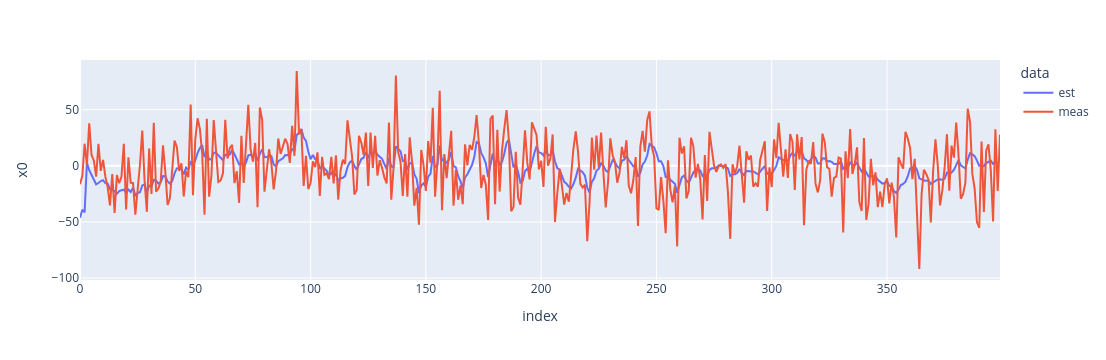

In [15]:
ex.line(err, y='x0', color='data')

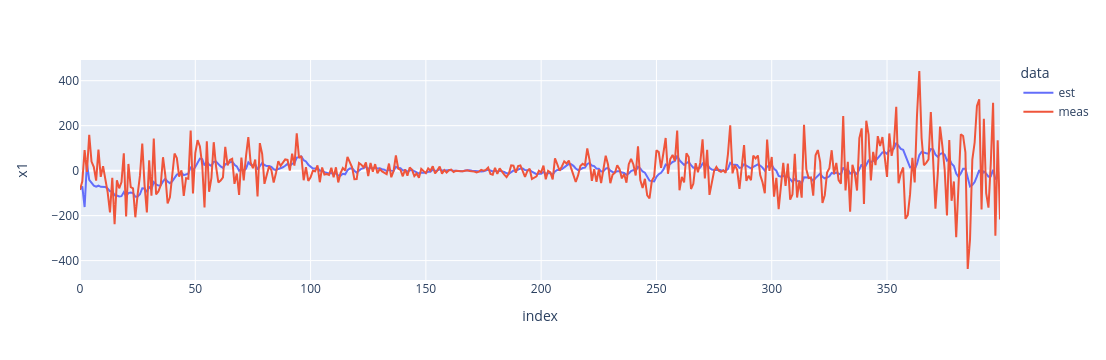

In [16]:
ex.line(err, y='x1', color='data')

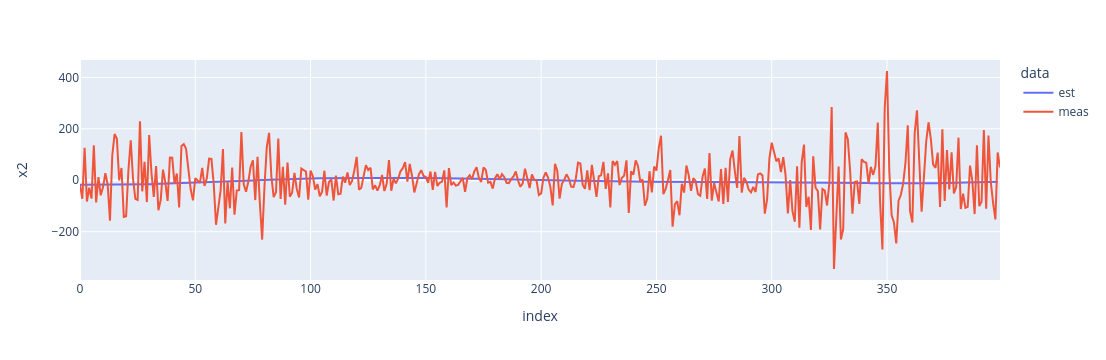

In [17]:
ex.line(err, y='x2', color='data')

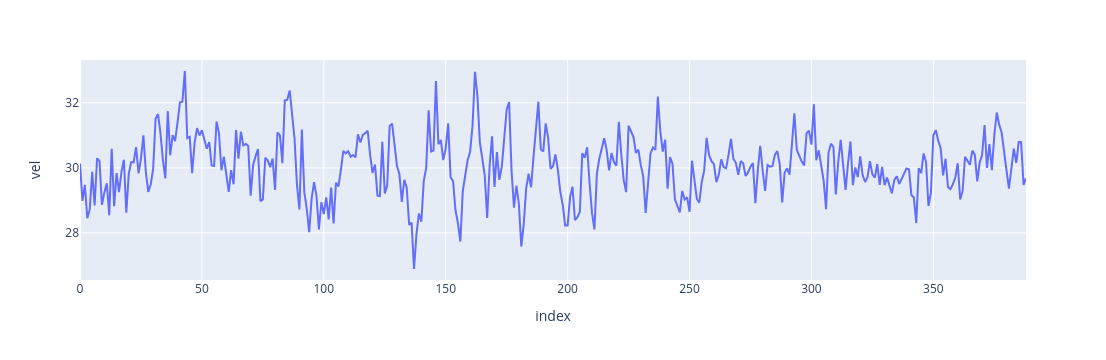

In [19]:
ex.line(to_df(np.linalg.norm(x_hat[10:,3:], axis=1), columns=['vel']), y='vel')

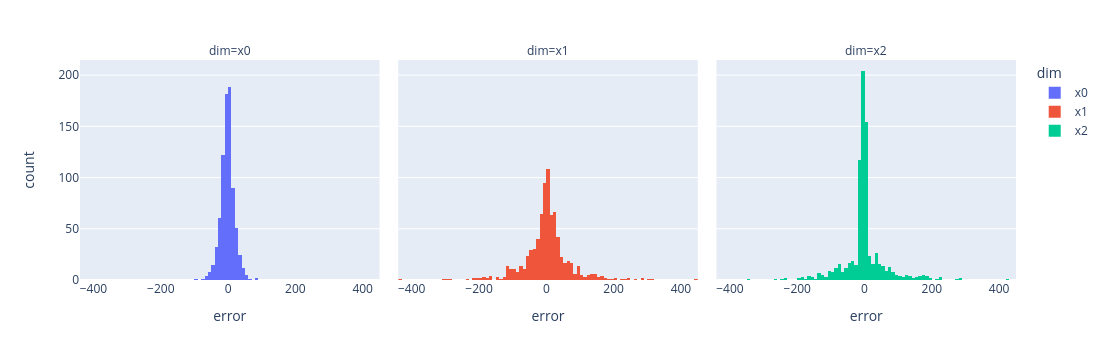

In [40]:
err_m = err.melt(['data'], ['x0', 'x1', 'x2', 'x3', 'x4', 'x5'], 'dim', 'error')

ex.histogram(err_m.query("dim in ['x0', 'x1', 'x2']"), x='error', color='dim', facet_col='dim')

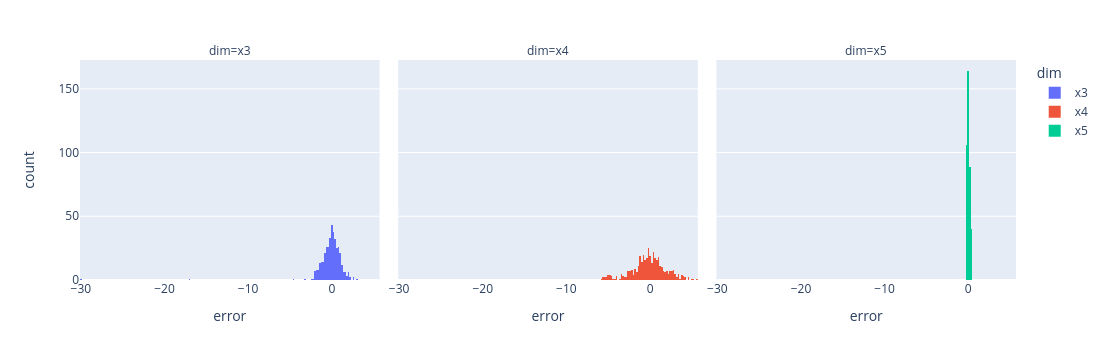

In [42]:
ex.histogram(err_m.query("dim in ['x3', 'x4', 'x5']"), x='error', color='dim', facet_col='dim')